##  Dynamic Models and Forecasting Stock Volatility using GARCH
<div style="text-align: right"> Fogli Alessandro </div>
<div style="text-align: right"> ID 231273 </div>
<div style="text-align: right"> Project #4 </div>

### Install packages

In [42]:
import scipy.stats as si
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pandas_datareader as pdr
import datetime
from IPython.display import display, HTML
import datetime as dt
import dataframe_image as dfi
import getFamaFrenchFactors as gff
import quandl
from fredapi import Fred
import config
from arch import arch_model
fred = Fred(api_key= config.fred_api)
QUANDL_KEY = config.quandl_key
quandl.ApiConfig.api_key = QUANDL_KEY
from scipy import stats
from statsmodels.base.model import GenericLikelihoodModel
from statsmodels.discrete.discrete_model import Probit
import statsmodels.formula.api as smf

### Data (all quarterly)

Get data of difference in yields between 10 year and 3 months U.S. Treasuries

In [43]:
t10y = fred.get_series('DGS10', observation_start="1962-01-02",observation_end= "2021-12-31",frequency='q')
t3mo = fred.get_series('TB3MS', observation_start="1962-01-02",observation_end= "2021-12-31",frequency='q')
term = t10y-t3mo
term = term.dropna()
#term = term.tolist()
term = term.to_frame().rename(columns={0: 'term'})
#240

Get data of Federal Funds Rate

In [44]:
funds_rate = fred.get_series('FEDFUNDS', observation_start="1962-01-02", observation_end= "2021-12-31" ,frequency='q')
funds_rate = funds_rate.to_frame().rename(columns={0: 'funds_rate'})

Get data of GDP Growth

In [45]:
gdp = fred.get_series('GDP', observation_start="1962-01-02", observation_end= "2021-12-31",frequency='q', units='pch')
#240 miss first quarter 2022
gdp = gdp.to_frame().rename(columns={0: 'gdp'})

NBER based Recession Indicators for the United States

In [46]:
nber = fred.get_series('USREC', observation_start="1962-01-01", observation_end= "2021-12-31" ,frequency='q')
nber = nber.astype(int)
nber = nber.to_frame().rename(columns={0: 'nber'})

Load data of S&P500 Futures - Jun 2022 expiring date

In [47]:
sp500_futures = pd.read_csv('S&P 500 Futures Historical Data.csv', index_col = 0)
sp500_futures.index = pd.to_datetime(sp500_futures.index, format= '%b %y') # date index transforming
sp500_futures.index = sp500_futures.index + pd.offsets.MonthEnd()
sp500_futures_rtn = sp500_futures['Change %']
sp500_futures_rtn= sp500_futures_rtn.str.replace('%','') # remove str % from value
sp500_futures_rtn = pd.to_numeric(sp500_futures_rtn, errors='coerce')
sp500_futures_rtn.fillna(0, inplace=True)
sp500_futures_rtn = sp500_futures_rtn.iloc[::-1]

Get data of S&P500

In [48]:
sp500 = quandl.get("MULTPL/SP500_REAL_PRICE_MONTH", start_date='1961-10-01', end_date='2021-12-31', collapse="monthly",authtoken="WcG92wpxYRRUQmyNxVxZ")
sp500_quarter_rtn = sp500.resample("3M").mean()
sp500_quarter_rtn = sp500_quarter_rtn.pct_change()
sp500_quarter_rtn = sp500_quarter_rtn.dropna()
sp500_quarter_rtn.drop(sp500_quarter_rtn.tail(1).index,inplace=True)
sp500_quarter_rtn = sp500_quarter_rtn.apply(lambda x: x* 100)
sp500_quarter_rtn = sp500_quarter_rtn['Value'].tolist()

Get Fama French Data

In [49]:
fama_data = gff.famaFrench3Factor(frequency="m")
fama_data.rename(columns={"date_ff_factors": 'Date'}, inplace=True)
fama_data.set_index('Date', inplace=True)
fama_data = fama_data.loc[fama_data.index >= '1961-10-01']
fama_data = fama_data.loc[fama_data.index <= '2021-12-31']
fama_data.columns = ['mkt', 'smb', 'hml', 'rf']
fama_data = fama_data.apply(lambda x: x/ 100) # transform data in ratio
fama_data.index = fama_data.index + pd.offsets.MonthBegin()

Get Stocks data for portfolio creation

In [50]:
tickers = ['DIS', 'CVX', 'WFC', 'BAC', 'IBM', 'PEP', 'JPM', 'GE', 'AXP', 'BRK-A']
start = dt.datetime(1972,1,1)
end = dt.datetime(2021,12,31)
portfolio = pdr.get_data_yahoo(tickers, start, end, interval='m')
portfolio.fillna(0, inplace=True)
portfolio.index = portfolio.index + pd.offsets.MonthEnd()

Get risky portfolio returns

In [51]:
single_stocks_rtn = portfolio['Adj Close'].pct_change(1, fill_method='ffill')
single_stocks_rtn.fillna(0, inplace=True)
stocks_rtn = single_stocks_rtn.replace([np.inf, -np.inf], 0)
wts1 = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1] #set weights of the stocks in the portfolio
port_ret = (stocks_rtn* wts1).sum(axis = 1) # total montlhy return balanced by sotcks weights
port_ret.drop(index = port_ret.index[0], axis=0, inplace=True)

Get safe portfolio return

In [52]:
safe_portfolio = single_stocks_rtn.join(fama_data['rf'].loc['1972-1-1' : '2021-12-31']).fillna(0)
wts2 = [0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.4]
safe_port_ret = (safe_portfolio * wts2).sum(axis = 1)

### Probit model

A probit regression is a version of the generalized linear model used to model dichotomous outcome variables. It uses the inverse standard normal distribution as a linear combination of the predictors. The binary outcome variable Y is assumed to have a Bernoulli distribution with parameter p (where the success probability is p∈(0,1). Hence, the probit link function is:
$$ probit(Y) = \sum_{k=0}^n \beta_{k} x_{ik} $$

The Probit model assumes that the firm’s probability of recession has a cumulative standard-normal distribution, rather than a logistic distribution. However, by multiplying the results of the logistic distribution by an appropriate coefficient the distribution of the Probit model can be obtained.

### Implementing Probit model with only Term as explanatory variable

In [53]:
term_nber = nber.join(term['term'])
all_factors =  term_nber.join(funds_rate['funds_rate']).join(gdp['gdp'])

fama_data_quarterly = fama_data.resample("3M").mean()
fama_data_quarterly = fama_data_quarterly.iloc[:-1, :]
fama_data_quarterly = fama_data_quarterly.pct_change()
fama_data_quarterly = fama_data_quarterly.iloc[1:, :]
mkt_tolist = fama_data_quarterly['mkt'].tolist()
#all_factors['market'] = sp500_quarter_rtn
all_factors['market'] = mkt_tolist

In [80]:
def prob_model(valx, valy, par, shiftvalue): #valx explanatory / valy dependent variable (always nber) / par is what result you want
    
    valx = valx.shift(shiftvalue) #switch lag and drop first val (Nan) of independent variable
 
    valx = valx.iloc[shiftvalue: , :] #drop firs row of dependent var
    valy = valy.iloc[shiftvalue: , :]
    X =  valx #factors
    y =  valy #nber
    X = sm.add_constant(X)
    model = Probit(y, X).fit(disp =False)
    match par:
        case 'rsquared':
            return model.prsquared
        case 'values':
            return model.fittedvalues
        case 'pvalues':
            return model.pvalues[1:].values
        case 'alpha':
            return model.params['const']
        case 'beta':
            return model.params[1:].values # get all betas without alpha

In [55]:
def normsdist(z):
    z = si.norm.cdf(z,0.0,1.0)
    return (z)

In [89]:
def plot_val(valx, valy, shiftvalue, start, end):

    values = prob_model(valx, valy, 'values', shiftvalue)
    valy = valy.iloc[shiftvalue: , :]
    bars = valy.reset_index().rename(columns={'index': 'date'})
    data= valy.reset_index().rename(columns={'index': 'date'})
    data['prob of recession'] = normsdist(values)

    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(data['date'],data['prob of recession'])
    bars.plot.area(ax=ax, figsize=(8, 5), x='date', alpha=0.3, color="gray")
  
    ax.legend()
    ax.set_ylabel('Probability')
    ax.set_title('Predictive power {} quarter ahead'.format(shiftvalue), size=18)
    plt.xlim(start, end)
    plt.ylim(0,0.8)

In [57]:
def fill(valx, valy):

    results = pd.DataFrame({ 
                    "Quarter ahead": [],               
                    "observations": [],
                    "Beta": [],
                    "Alpha": [],
                    "R-sq": [],
                    "p-val": [],
                    
                })
    for i in range(1,13):
        observation = len(prob_model(valx, valy, 'values',i))
        beta = prob_model(valx, valy, 'beta',i)
        pval = prob_model(valx, valy, 'pvalues',i)
        alpha = prob_model(valx, valy, 'alpha',i)
        rsq = prob_model(valx, valy, 'rsquared',i)
        ahead = i

        results.loc[i-1] = pd.Series({'Quarter ahead': ahead, 'observations': observation, 'Beta': beta[0], 'Alpha': alpha,'R-sq': rsq, 'p-val': pval[0]}) #'Alpha': alpha,
        
   
    results.set_index('Quarter ahead', inplace=True)
    global greater
    results['R-sq'] = pd.to_numeric(results['R-sq'])
    greater = results[['R-sq']].idxmax()
    plot_val(valx, valy, int(greater), "1963-04-01","2021-10-01")
    #dfi.export(results, 'single_factor_table.png')


### Probit Dynamic model with 4 factors as explanatory variables

In [81]:
def fill2(valx, valy):

    results = pd.DataFrame({ 
                    "Quarter ahead": [],               
                    "observations": [],
                    "Beta term": [], "p-val term": [],
                    "Beta funds_rate": [], "p-val funds_rate": [],
                    "Beta gdp": [], "p-val gdp": [],
                    "Beta market": [], "p-val market": [],
                    "Alpha": [],
                    "R-sq": [],
                    
                    
                })
    for i in range(1,13):
        observation = len(prob_model(valx, valy, 'values',i))
        beta = prob_model(valx, valy, 'beta',i)
        pval = prob_model(valx, valy, 'pvalues',i)
        alpha = prob_model(valx, valy, 'alpha',i)
        rsq = prob_model(valx, valy, 'rsquared',i)
        ahead = i

        results.loc[i-1] = pd.Series({
                    'Quarter ahead': ahead, 
                    'observations': observation, 
                    'Beta term': beta[0], "p-val term": pval[0],
                    "Beta funds_rate": beta[1], "p-val funds_rate": pval[1],
                    "Beta gdp": beta[2], "p-val gdp": pval[2],
                    "Beta market": beta[3], "p-val market": pval[3],
                    'Alpha': alpha,
                    'R-sq': rsq, 
                })
   
    results.set_index('Quarter ahead', inplace=True)
    global greater2

    display(HTML(results.to_html(classes='table table-stripde')))
    results['R-sq'] = pd.to_numeric(results['R-sq'])
    greater2 = results[['R-sq']].idxmax()
    #dfi.export(results, 'multi_factor_table.png')
fill2(all_factors, nber)

C:\Users\aless\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aless\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aless\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aless\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

,observations,Beta term,p-val term,Beta funds_rate,p-val funds_rate,Beta gdp,p-val gdp,Beta market,p-val market,Alpha,R-sq
Quarter ahead,,,,,,,,,,,
1.0,239.0,2.818699,7.490396e-09,-0.504318,0.017199,0.080689,0.140631,-0.173063,0.130682,-1.673858,0.603247
2.0,238.0,1.535694,3.782236e-05,-0.512241,0.001658,0.103283,0.029693,-0.170396,0.098983,-1.400993,0.420434
3.0,237.0,0.552024,1.377662e-01,-0.560291,0.000228,0.125365,0.006212,-0.157760,0.120443,-1.284292,0.361508
4.0,236.0,-0.218653,5.834296e-01,-0.523263,0.000131,0.136154,0.002242,-0.073633,0.497821,-1.358583,0.327156
5.0,235.0,-0.679308,1.486455e-01,-0.566496,0.000070,0.140919,0.003931,-0.033250,0.776563,-1.323425,0.341961
6.0,234.0,-1.201730,4.275925e-02,-0.491195,0.000220,0.138398,0.007791,0.065792,0.654678,-1.492953,0.305063
7.0,233.0,-0.858281,1.330317e-01,-0.404214,0.001102,0.080959,0.091005,0.315075,0.027782,-1.688500,0.237936
8.0,232.0,-0.541356,3.008501e-01,-0.308399,0.006944,0.043712,0.326030,0.340612,0.013319,-1.607377,0.173917
9.0,231.0,-0.750720,1.451290e-01,-0.237679,0.027309,0.056965,0.184456,0.102703,0.456731,-1.296286,0.102176


Above the results of the dynamic models - add of lag recession as exlanatory variable.  
We can notice that the most robust factors -the ones that are statistically significant with ore frequency- are Funds rate and Gdp growth.  
Now we can run a static model for predicting recession by using these robust factors.

In [59]:
all_factors2 = all_factors.drop(['market'], axis=1).drop(['gdp'], axis=1).drop(['nber'], axis=1)

In [82]:
def fill3(valx, valy):

    results = pd.DataFrame({ 
                    "Quarter ahead": [],               
                    "observations": [],
                    "Beta funds_rate": [], "p-val funds_rate": [],
                    "Beta gdp": [], "p-val gdp": [],
                    "Alpha": [],
                    "R-sq": [],
                    
                    
                })
    for i in range(1,13):
        observation = len(prob_model(valx, valy, 'values',i))
        beta = prob_model(valx, valy, 'beta',i)
        pval = prob_model(valx, valy, 'pvalues',i)
        alpha = prob_model(valx, valy, 'alpha',i)
        rsq = prob_model(valx, valy, 'rsquared',i)
        ahead = i

        results.loc[i-1] = pd.Series({
                    'Quarter ahead': ahead, 
                    'observations': observation, 
                    "Beta funds_rate": beta[0], "p-val funds_rate": pval[0],
                    "Beta gdp": beta[1], "p-val gdp": pval[1],
                    'Alpha': alpha,
                    'R-sq': rsq, 
                })
   
    results.set_index('Quarter ahead', inplace=True)
    global greater3

    display(HTML(results.to_html(classes='table table-stripde')))
    results['R-sq'] = pd.to_numeric(results['R-sq'])
    greater3 = results[['R-sq']].idxmax()
    #dfi.export(results, 'multi_factor_table.png')
fill3(all_factors2, nber)

,observations,Beta funds_rate,p-val funds_rate,Beta gdp,p-val gdp,Alpha,R-sq
Quarter ahead,,,,,,,
1.0,239.0,-0.062022,0.542360,0.139974,0.000017,-1.929667,0.165537
2.0,238.0,-0.274094,0.014267,0.139696,0.000060,-1.707169,0.246907
3.0,237.0,-0.477383,0.000185,0.131393,0.000418,-1.491147,0.318090
4.0,236.0,-0.542947,0.000050,0.117600,0.001806,-1.357249,0.319388
5.0,235.0,-0.592785,0.000036,0.104683,0.007285,-1.239975,0.317046
6.0,234.0,-0.516384,0.000102,0.091073,0.014568,-1.184221,0.258348
7.0,233.0,-0.388421,0.001000,0.072664,0.037426,-1.148481,0.174203
8.0,232.0,-0.297915,0.006628,0.055635,0.098869,-1.111795,0.111605
9.0,231.0,-0.255411,0.016664,0.039156,0.240910,-1.045717,0.075026


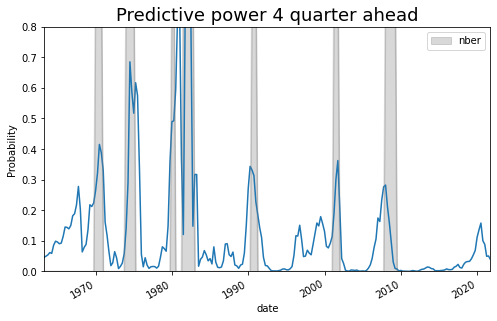

In [90]:
plot_val(all_factors2, nber, int(greater3), "1963-04-01","2021-10-01")

The best static model with Funds rate and Gdp growth as robust explanatory variable (McFadden R-Sq 0.319) is 4 quarter ahead.  
By looking at the plot we can notice that a good threshold of probability of recession that we can use for starting to hedge is 0.25 since it fitted almost all the recessions over the whole period.

Optimization terminated successfully.
         Current function value: 0.253614
         Iterations 7


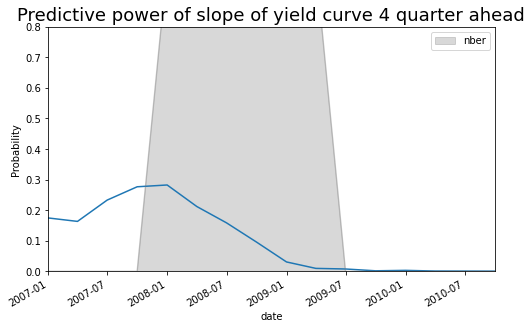

In [62]:
plot_val(all_factors2, nber, int(greater3), "2007-01-01","2010-10-01")

By plotting the period of 2008 recession, due to the above reflection I can say that my general strategy that can fit the whole period is to hedge when the probability of recession is around 25%, so in this situation I would have hedged in the last quarter of 2007 in August.

### Analysis of different strategies

Let's assume we built a risky portfolio of $ 1000000 composed by 10 stocks on 2007-06, now let's consider how it would have been changed during the lowest period of the market - first quarter 2009 - and at the end of the recession (third quarter of 2009), based on three different strategies:  
- Just holding the stocks
- Hedging the market by buying the S&P500 Futures
- Hedging by switching the composition of the portfolio towards around 40% of riskfree.

#### Just hold stocks

In [63]:
port_ret_crisis_full = port_ret.loc['2007-5-30' : '2009-3-31']
portfolio_cum_returns = (port_ret_crisis_full + 1).cumprod()
portfolio_no_hedge_value = (round(portfolio_cum_returns[-1]*1000000))
portfolio_no_hedge_value_change = (portfolio_cum_returns[-1]-portfolio_cum_returns[0])*100
print('With a portfolio of $1000000 at 2006-09-30 without hedging I would have had {} $ at 2009-3-31'.format(portfolio_no_hedge_value))
print('It is {}% of the total investment'.format(round(portfolio_no_hedge_value_change)))

With a portfolio of $1000000 at 2006-09-30 without hedging I would have had 540949 $ at 2009-3-31
It is -48% of the total investment


### Hedge by shorting S&P500 Futures

We can compute the number of futures needed with the following formula:  


$$N_{futures} : \beta(\frac{Portfolio_{value}}{Futures_{price}* Futures_{point value}})$$

In [64]:
def beta(valx, valy):
    X = valx
    y = valy
    slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)
    return round(slope,4)

We need to compute the hedge ratio up to the period in which we decide to hedge

In [65]:
sp500_up_to_hedge = sp500_futures_rtn.loc['1997-11-01': '2007-08-31']
port_ret_up_to_hedge = port_ret.loc['1997-11-01': '2007-08-31'].apply(lambda x: x* 100)

In [66]:
def futures_hedging_number():
    slope = beta(sp500_up_to_hedge, port_ret_up_to_hedge) #data len should match, we have less futures historical data
    sp500_futures['Price']= sp500_futures['Price'].str.replace(',','')
    futures_price = pd.to_numeric(sp500_futures['Price'])
    futures_price = futures_price.iloc[0]
    futures_price = pd.to_numeric(futures_price)
    futures_number = slope * (1000000/(futures_price*50)) #we are multiplying the futures price for the point value, here 50$ for S&P500 E-mini
    return futures_number
futures_hedging_number()

4.026092628832354

Based on that I know that in August 2007 2007 I should have shorted #4 S&P500 Futures, that's because I was long with my stocks portfolio and I want to be short on the market.

In [67]:
def percentage_change(current_value, previous_value):
    change = ((current_value - previous_value) / previous_value) * 100.0
    return change

In [68]:
futures_price_start = sp500_futures['Price'].loc['2007-8-31']
futures_price_start = pd.to_numeric(futures_price_start)
futures_price_end = sp500_futures['Price'].loc['2009-3-31']
futures_price_end = pd.to_numeric(futures_price_end)

contract_value_start = (futures_price_start * futures_hedging_number())*50 # value of the futures contract at the start of the period
contract_value_end= (futures_price_end * futures_hedging_number())*50 # value of the futures contract at the end of the period
futures_gain = (percentage_change(contract_value_end, contract_value_start)*-1) # multiplied for -1 since we are shorting so we get the opposite of the actual return
short_position_end = (contract_value_start*(futures_gain/100))+ contract_value_start # invested futures amount + futures net los/gain
futures_net_gain = contract_value_start * (futures_gain/100)
print('Short position at 2007-9-30 --> {} $'.format(round(contract_value_start)))
print('S&P500 holded equivalent price 2009-3-31 --> {} $'.format(round(contract_value_end)))

print('Position at 2009-3-31 --> {}$'.format(round(short_position_end)))

print('gain of {} %'.format(round(futures_gain)))
print('net gain {} $'.format(round(futures_net_gain)))
print('portfolio + hedge gain --> {} $'.format(round(portfolio_no_hedge_value + futures_net_gain)))
print('With hedge {} % of initial investment'.format(round(percentage_change((portfolio_no_hedge_value + futures_net_gain), 1000000))))

Short position at 2007-9-30 --> 297277 $
S&P500 holded equivalent price 2009-3-31 --> 159987 $
Position at 2009-3-31 --> 434566$
gain of 46 %
net gain 137290 $
portfolio + hedge gain --> 678239 $
With hedge -32 % of initial investment


Assuming I shorted in August 2007, by shorting my optimal hedge ratio of #4 S&P5OO Futures I would have had a loss of -32% in March 2009, which is the moment of highest loss of the market in 2008-2009 recession.  
If I hadn't hedged I would have had a loss of -48% at that moment from my portfolio of stocks.  
By hedging I could have had a 16% reduction of the total loss without hedging (48%), in that situation, whit a portfolio of \$1 million, the savings amount is worth \$ 137000.  
In this situation short the S&P500 to reduce the systematic risk would have been a good choice.

#### Shift toward safer portfolio

In [69]:
safe_port_ret_crisis = safe_port_ret.loc['2007-5-30' : '2009-3-31']
safe_cum_returns = (safe_port_ret_crisis + 1).cumprod()
safe_portfolio_value = (round(safe_cum_returns[-1]*1000000))
print('With a portfolio of $1000000 shifted towards 40% of riskfree in 2007-05-30  I would have had {} $ at 2009-3-31'.format(safe_portfolio_value))
print('It is {}% of the total investment'.format(round((safe_cum_returns[-1]-safe_cum_returns[0])*100)))

With a portfolio of $1000000 shifted towards 40% of riskfree in 2007-05-30  I would have had 708163 $ at 2009-3-31
It is -31% of the total investment


As we can see if I have shifted towards a safer portfolio with around 40% of riskfree I would have had a loss of -31% in 2008 crisis at the lowest level of the market in March 2009.  
It is a better result respect to the S&P500 Futures short that would have had a loss of 32%.  
In conclusion the best strategy it would have been to shift to a safer portfolio by adding a riskfree (-31% over the period), then even shorting the market would have been a good move but with worst results (-32% over the period).  
Finally of course only holding our risky stocks would have been the worst choice (-48% over the period)

### Garch model

Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model, the ARCH model specifies the conditional
variance as a linear function of past sample variances, while the GARCH model adds
lagged conditional variances to the specification.  
Here following the GARCH formula:  
$$ \sigma_{t}^{2} = \alpha_{0}+\alpha_{1}\epsilon_{t-1}^{2}+\beta_{1}\sigma_{t-1}^{2}+K_{t}$$  
In the case of a GARCH(1,1) model, must be less than 1,
otherwise, the model is unstable.

In [70]:
def garch(valx):
    model = arch_model(valx, mean='Zero', vol='GARCH', p=1, o=0, q=1)
    model_fitted = model.fit(disp='off')
    #print(model_fitted.summary())
    #model_fitted.plot(annualize='D')
    return model_fitted.conditional_volatility

In [71]:
market_volatility = pd.DataFrame(data=garch(all_factors['market']))
term_volatility = pd.DataFrame(data=garch(all_factors['term']))
funds_rate_volatility = pd.DataFrame(data=garch(all_factors['funds_rate']))

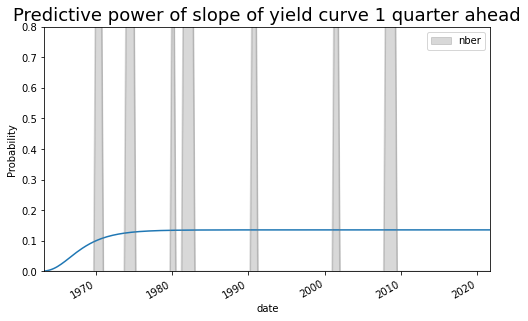

In [83]:
fill(market_volatility, nber)

Market excess of return conditional voltility predictive power in a static Probit model, above we can see plotted the lag model with the highest $R^{2}$

C:\Users\aless\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aless\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aless\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aless\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

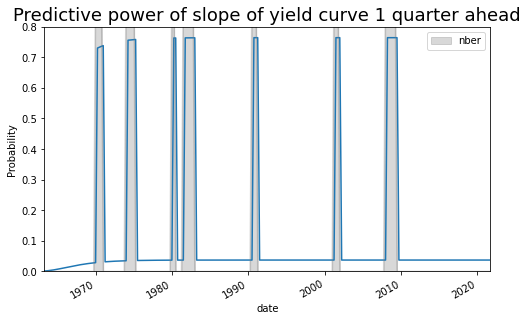

In [84]:
fill(market_volatility.join(nber), nber)

Market excess of return conditional voltility predictive power in a dynamic Probit model, above we can see plotted the lag model with the highest $R^{2}$

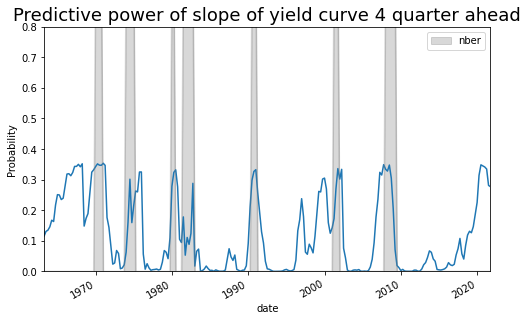

In [85]:
fill(term_volatility, nber)

Treasury term spread conditional voltility predictive power in a static Probit model, above we can see plotted the lag model with the highest $R^{2}$

C:\Users\aless\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aless\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aless\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aless\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

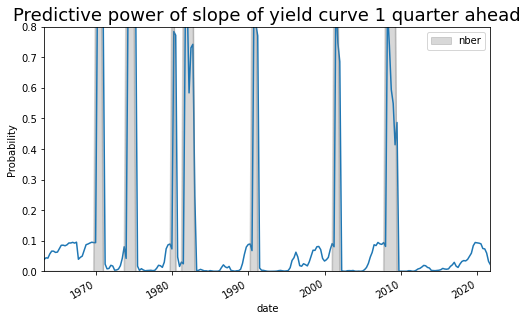

In [86]:
fill(term_volatility.join(nber), nber)

Treasury term spread conditional voltility predictive power in a dynamic Probit model, above we can see plotted the lag model with the highest $R^{2}$

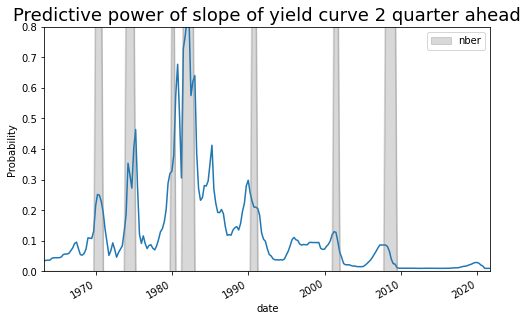

In [87]:
fill(funds_rate_volatility, nber)

Funds rate conditional volatility predictive power in a static Probit model, above we can see plotted the lag model with the highest $R^{2}$

C:\Users\aless\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aless\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aless\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aless\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

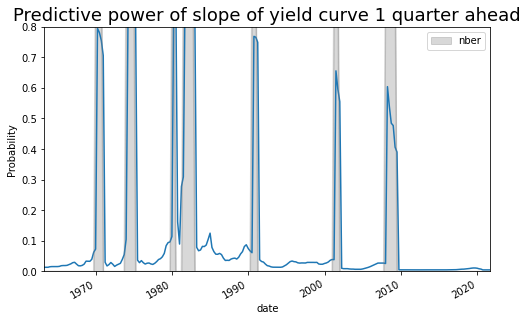

In [88]:
fill(funds_rate_volatility.join(nber), nber)

Funds rate conditional volatility predictive power in a dynamic Probit model, above we can see plotted the lag model with the highest $R^{2}$